In [1]:
import pandas as pd
import numpy as np
import copy
import time
import talib
import copy
from talib import abstract 
import matplotlib.pyplot as plt
from stocktrends import Renko
import statsmodels.api as sm

In [2]:
icici = pd.read_csv('icici5.csv',index_col='date')
axis = pd.read_csv('sbi5.csv',index_col=['date'])

federal = pd.read_csv('federal5.csv',index_col=['date'])
sbi = pd.read_csv('axis5.csv',index_col=['date'])

In [52]:
a = ['icici','federal','sbi','axis']
tickers_signal = {}
ticker_signal = {}
ticker_ret = {}
w = pd.concat([icici,federal,sbi,axis],axis=1)
w.dropna(inplace=True)
e = w.transpose()
e = e.values
axis.dropna(inplace=True)
idx = pd.MultiIndex.from_product([['icici','federal','sbi','axis'],axis.columns.values],names=['ticker', 'data'])
q = pd.DataFrame(e,idx,columns = axis.iloc[:-3,:].index.values)
q = q.transpose()
t = q.copy()
t

ticker                icici                                   federal         \
data                   open    high     low   close    volume    open   high   
2021-01-05 03:45:00  526.65  526.65  523.00  524.60  895543.0   70.00  70.25   
2021-01-05 03:50:00  524.60  524.65  523.40  524.35  447023.0   70.15  70.15   
2021-01-05 03:55:00  524.30  527.40  524.10  526.75  717521.0   69.70  69.95   
2021-01-05 04:00:00  527.00  528.00  526.60  526.90  478715.0   69.85  70.05   
2021-01-05 04:05:00  526.95  527.30  526.05  526.15  338880.0   69.95  70.10   
...                     ...     ...     ...     ...       ...     ...    ...   
2021-10-04 09:20:00  700.50  700.55  699.70  700.00  165681.0   84.95  84.95   
2021-10-04 09:25:00  700.20  700.75  700.00  700.35  147029.0   84.85  84.95   
2021-10-04 09:30:00  700.35  700.40  699.80  699.90  242140.0   84.80  85.15   
2021-10-04 09:35:00  699.95  700.45  699.80  700.00  223271.0   85.15  85.25   
2021-10-04 09:40:00  700.10  701.00  699.65  700.20  215495.0   85.20  85.30   

ticker                                           sbi                          \
data                   low  close     volume    open    high     low   close   
2021-01-05 03:45:00  69.25  70.15  1514727.0  618.00  623.80  618.00  623.60   
2021-01-05 03:50:00  69.65  69.70   769168.0  623.55  624.50  621.75  623.85   
2021-01-05 03:55:00  69.60  69.90   489853.0  624.10  632.90  623.90  631.70   
2021-01-05 04:00:00  69.85  69.95   634138.0  631.75  636.40  631.30  634.55   
2021-01-05 04:05:00  69.70  69.75   742620.0  634.75  642.60  633.90  641.50   
...                    ...    ...        ...     ...     ...     ...     ...   
2021-10-04 09:20:00  84.60  84.90   311038.0  777.55  778.35  776.50  777.35   
2021-10-04 09:25:00  84.80  84.80   206281.0  777.55  778.70  777.05  778.55   
2021-10-04 09:30:00  84.80  85.15   453945.0  778.70  780.05  778.70  779.80   
2021-10-04 09:35:00  85.15  85.20   490259.0  779.75  780.10  779.20  779.75   
2021-10-04 09:40:00  85.10  85.10   388915.0  779.65  780.10  778.25  780.00   

ticker                            axis                                     
data                    volume    open    high     low   close     volume  
2021-01-05 03:45:00   635558.0  278.05  279.75  277.40  278.80  1408571.0  
2021-01-05 03:50:00   260873.0  278.80  279.00  277.75  278.40   855794.0  
2021-01-05 03:55:00   982596.0  278.40  278.65  278.05  278.65   559869.0  
2021-01-05 04:00:00  1369223.0  278.70  279.20  278.50  278.80   484918.0  
2021-01-05 04:05:00  1777693.0  278.85  279.05  278.15  278.25   476560.0  
...                        ...     ...     ...     ...     ...        ...  
2021-10-04 09:20:00    62113.0  462.95  463.15  462.80  463.10   212607.0  
2021-10-04 09:25:00    80740.0  463.10  463.40  463.00  463.15   361704.0  
2021-10-04 09:30:00   277236.0  463.20  463.40  463.00  463.25   404284.0  
2021-10-04 09:35:00   199813.0  463.25  463.85  463.05  463.15   603375.0  
2021-10-04 09:40:00   236256.0  463.15  463.20  462.35  462.50   299690.0  

[13847 rows x 20 columns]

In [4]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return (df["MACD"],df["Signal"])

def atr(Df,n):
    df = Df.copy()
    df['atr'] = abstract.ATR(df,n)
    return df

In [9]:
tickers = ['icici','federal','sbi','axis']

In [13]:
for ticker in tickers:
    t.loc[:,(ticker,'ATR')] = abstract.ATR(t[ticker],120)
    t.loc[:,(ticker,'rolling_max')] = t[ticker]['high'].rolling(20).max()
    t.loc[:,(ticker,'rolling_min')] = t[ticker]['low'].rolling(20).min()
    t.loc[:,(ticker,'rolling_vol')] = t[ticker]['volume'].rolling(20).max()
    t.loc[:,(ticker,'slope')] = abstract.LINEARREG_ANGLE(t[ticker],5)
    ticker_signal[ticker] = ''
    ticker_ret[ticker] = []
t

ticker                icici                                   federal         \
data                   open    high     low   close    volume    open   high   
2021-01-05 03:45:00  526.65  526.65  523.00  524.60  895543.0   70.00  70.25   
2021-01-05 03:50:00  524.60  524.65  523.40  524.35  447023.0   70.15  70.15   
2021-01-05 03:55:00  524.30  527.40  524.10  526.75  717521.0   69.70  69.95   
2021-01-05 04:00:00  527.00  528.00  526.60  526.90  478715.0   69.85  70.05   
2021-01-05 04:05:00  526.95  527.30  526.05  526.15  338880.0   69.95  70.10   
...                     ...     ...     ...     ...       ...     ...    ...   
2021-10-04 09:20:00  700.50  700.55  699.70  700.00  165681.0   84.95  84.95   
2021-10-04 09:25:00  700.20  700.75  700.00  700.35  147029.0   84.85  84.95   
2021-10-04 09:30:00  700.35  700.40  699.80  699.90  242140.0   84.80  85.15   
2021-10-04 09:35:00  699.95  700.45  699.80  700.00  223271.0   85.15  85.25   
2021-10-04 09:40:00  700.10  701.00  699.65  700.20  215495.0   85.20  85.30   

ticker                                        ...       sbi              \
data                   low  close     volume  ...       ATR rolling_max   
2021-01-05 03:45:00  69.25  70.15  1514727.0  ...       NaN         NaN   
2021-01-05 03:50:00  69.65  69.70   769168.0  ...       NaN         NaN   
2021-01-05 03:55:00  69.60  69.90   489853.0  ...       NaN         NaN   
2021-01-05 04:00:00  69.85  69.95   634138.0  ...       NaN         NaN   
2021-01-05 04:05:00  69.70  69.75   742620.0  ...       NaN         NaN   
...                    ...    ...        ...  ...       ...         ...   
2021-10-04 09:20:00  84.60  84.90   311038.0  ...  1.678713      781.15   
2021-10-04 09:25:00  84.80  84.80   206281.0  ...  1.678473      781.15   
2021-10-04 09:30:00  84.80  85.15   453945.0  ...  1.676986      781.15   
2021-10-04 09:35:00  85.15  85.20   490259.0  ...  1.670511      781.15   
2021-10-04 09:40:00  85.10  85.10   388915.0  ...  1.672007      781.15   

ticker                                                      axis              \
data                rolling_min rolling_vol      slope       ATR rolling_max   
2021-01-05 03:45:00         NaN         NaN        NaN       NaN         NaN   
2021-01-05 03:50:00         NaN         NaN        NaN       NaN         NaN   
2021-01-05 03:55:00         NaN         NaN        NaN       NaN         NaN   
2021-01-05 04:00:00         NaN         NaN        NaN       NaN         NaN   
2021-01-05 04:05:00         NaN         NaN  77.863176       NaN         NaN   
...                         ...         ...        ...       ...         ...   
2021-10-04 09:20:00       775.4    212945.0 -21.801409  1.127011       464.4   
2021-10-04 09:25:00       775.4    212945.0 -12.133880  1.120953       464.4   
2021-10-04 09:30:00       775.4    277236.0  14.305552  1.114945       464.4   
2021-10-04 09:35:00       775.4    277236.0  34.019350  1.112320       464.4   
2021-10-04 09:40:00       775.4    277236.0  33.023868  1.110134       464.4   

ticker                                                 
data                rolling_min rolling_vol     slope  
2021-01-05 03:45:00         NaN         NaN       NaN  
2021-01-05 03:50:00         NaN         NaN       NaN  
2021-01-05 03:55:00         NaN         NaN       NaN  
2021-01-05 04:00:00         NaN         NaN       NaN  
2021-01-05 04:05:00         NaN         NaN -4.004173  
...                         ...         ...       ...  
2021-10-04 09:20:00      459.75    757572.0  4.289153  
2021-10-04 09:25:00      459.75    757572.0  6.277298  
2021-10-04 09:30:00      459.75    757572.0  5.142765  
2021-10-04 09:35:00      459.75    757572.0  3.148096  
2021-10-04 09:40:00      459.80    757572.0 -6.842773  

[13847 rows x 40 columns]

In [16]:
def renko_df(df):
    r = df.copy()
    r.reset_index(inplace = True)
    r = r.iloc[:,[0,1,2,3,4,5]]
    r.columns = ['date','open','high','low','close','volume']
    print(r)
    df2 = Renko(r)
    df2.brick_size = max(0.5,round(atr(df,120)['atr'][-1],0))
    renko_DF = df2.get_ohlc_data()
    renko_DF['bar_num'] = np.where(renko_DF['uptrend'] == True,1,np.where(renko_DF['uptrend'] == False,-1,0))
    for i in range(1,len(renko_DF['bar_num'])):
        if renko_DF["bar_num"][i]>0 and renko_DF["bar_num"][i-1]>0:
            renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]
        elif renko_DF["bar_num"][i]<0 and renko_DF["bar_num"][i-1]<0:
            renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]
    renko_DF.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_DF
ohlc_renko = {}
renko_df(t['axis'])

                      date    open    high     low   close     volume
0      2021-01-05 03:45:00  278.05  279.75  277.40  278.80  1408571.0
1      2021-01-05 03:50:00  278.80  279.00  277.75  278.40   855794.0
2      2021-01-05 03:55:00  278.40  278.65  278.05  278.65   559869.0
3      2021-01-05 04:00:00  278.70  279.20  278.50  278.80   484918.0
4      2021-01-05 04:05:00  278.85  279.05  278.15  278.25   476560.0
...                    ...     ...     ...     ...     ...        ...
13842  2021-10-04 09:20:00  462.95  463.15  462.80  463.10   212607.0
13843  2021-10-04 09:25:00  463.10  463.40  463.00  463.15   361704.0
13844  2021-10-04 09:30:00  463.20  463.40  463.00  463.25   404284.0
13845  2021-10-04 09:35:00  463.25  463.85  463.05  463.15   603375.0
13846  2021-10-04 09:40:00  463.15  463.20  462.35  462.50   299690.0

[13847 rows x 6 columns]


<ipython-input-16-a97c41e2237d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]
<ipython-input-16-a97c41e2237d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]


,date,open,high,low,close,uptrend,bar_num
0,2021-01-05 03:45:00,277.0,278.0,277.0,278.0,True,1
1,2021-01-05 05:35:00,278.0,279.0,278.0,279.0,True,2
2,2021-01-05 06:45:00,279.0,280.0,279.0,280.0,True,3
3,2021-01-05 08:50:00,280.0,281.0,280.0,281.0,True,4
4,2021-01-05 09:00:00,281.0,282.0,281.0,282.0,True,5
...,...,...,...,...,...,...,...
2965,2021-10-04 06:25:00,458.0,459.0,458.0,459.0,True,7
2966,2021-10-04 07:20:00,459.0,460.0,459.0,460.0,True,8
2967,2021-10-04 08:10:00,460.0,461.0,460.0,461.0,True,9
2968,2021-10-04 08:20:00,461.0,462.0,461.0,462.0,True,10


In [17]:
tt = t.copy()

In [18]:
ticker_signal = {}
ticker_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_df(tt[ticker])
    renko.columns = ["date","open","high","low","close","uptrend","bar_num"]
    tt.loc[:,(ticker,'date')] = tt[ticker].index
    ohlc_renko[ticker] = tt[ticker].merge(renko.loc[:,["date","bar_num"]],how="outer",on="date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["macd"]= MACD(ohlc_renko[ticker],12,26,9)[0]
    ohlc_renko[ticker]["macd_sig"]= MACD(ohlc_renko[ticker],12,26,9)[1]
    ohlc_renko[ticker]["macd_slope"] = slope(ohlc_renko[ticker]["macd"],5)
    ohlc_renko[ticker]["macd_sig_slope"] = slope(ohlc_renko[ticker]["macd_sig"],5)
    ticker_signal[ticker] = ""
    ticker_ret[ticker] = []
ohlc_renko

merging for  icici
                      date    open    high     low   close    volume
0      2021-01-05 03:45:00  526.65  526.65  523.00  524.60  895543.0
1      2021-01-05 03:50:00  524.60  524.65  523.40  524.35  447023.0
2      2021-01-05 03:55:00  524.30  527.40  524.10  526.75  717521.0
3      2021-01-05 04:00:00  527.00  528.00  526.60  526.90  478715.0
4      2021-01-05 04:05:00  526.95  527.30  526.05  526.15  338880.0
...                    ...     ...     ...     ...     ...       ...
13842  2021-10-04 09:20:00  700.50  700.55  699.70  700.00  165681.0
13843  2021-10-04 09:25:00  700.20  700.75  700.00  700.35  147029.0
13844  2021-10-04 09:30:00  700.35  700.40  699.80  699.90  242140.0
13845  2021-10-04 09:35:00  699.95  700.45  699.80  700.00  223271.0
13846  2021-10-04 09:40:00  700.10  701.00  699.65  700.20  215495.0

[13847 rows x 6 columns]


<ipython-input-16-a97c41e2237d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]
<ipython-input-16-a97c41e2237d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]


merging for  federal
                      date   open   high    low  close     volume
0      2021-01-05 03:45:00  70.00  70.25  69.25  70.15  1514727.0
1      2021-01-05 03:50:00  70.15  70.15  69.65  69.70   769168.0
2      2021-01-05 03:55:00  69.70  69.95  69.60  69.90   489853.0
3      2021-01-05 04:00:00  69.85  70.05  69.85  69.95   634138.0
4      2021-01-05 04:05:00  69.95  70.10  69.70  69.75   742620.0
...                    ...    ...    ...    ...    ...        ...
13842  2021-10-04 09:20:00  84.95  84.95  84.60  84.90   311038.0
13843  2021-10-04 09:25:00  84.85  84.95  84.80  84.80   206281.0
13844  2021-10-04 09:30:00  84.80  85.15  84.80  85.15   453945.0
13845  2021-10-04 09:35:00  85.15  85.25  85.15  85.20   490259.0
13846  2021-10-04 09:40:00  85.20  85.30  85.10  85.10   388915.0

[13847 rows x 6 columns]


<ipython-input-16-a97c41e2237d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]
<ipython-input-16-a97c41e2237d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]


merging for  sbi
                      date    open    high     low   close     volume
0      2021-01-05 03:45:00  618.00  623.80  618.00  623.60   635558.0
1      2021-01-05 03:50:00  623.55  624.50  621.75  623.85   260873.0
2      2021-01-05 03:55:00  624.10  632.90  623.90  631.70   982596.0
3      2021-01-05 04:00:00  631.75  636.40  631.30  634.55  1369223.0
4      2021-01-05 04:05:00  634.75  642.60  633.90  641.50  1777693.0
...                    ...     ...     ...     ...     ...        ...
13842  2021-10-04 09:20:00  777.55  778.35  776.50  777.35    62113.0
13843  2021-10-04 09:25:00  777.55  778.70  777.05  778.55    80740.0
13844  2021-10-04 09:30:00  778.70  780.05  778.70  779.80   277236.0
13845  2021-10-04 09:35:00  779.75  780.10  779.20  779.75   199813.0
13846  2021-10-04 09:40:00  779.65  780.10  778.25  780.00   236256.0

[13847 rows x 6 columns]


<ipython-input-16-a97c41e2237d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]
<ipython-input-16-a97c41e2237d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]


merging for  axis
                      date    open    high     low   close     volume
0      2021-01-05 03:45:00  278.05  279.75  277.40  278.80  1408571.0
1      2021-01-05 03:50:00  278.80  279.00  277.75  278.40   855794.0
2      2021-01-05 03:55:00  278.40  278.65  278.05  278.65   559869.0
3      2021-01-05 04:00:00  278.70  279.20  278.50  278.80   484918.0
4      2021-01-05 04:05:00  278.85  279.05  278.15  278.25   476560.0
...                    ...     ...     ...     ...     ...        ...
13842  2021-10-04 09:20:00  462.95  463.15  462.80  463.10   212607.0
13843  2021-10-04 09:25:00  463.10  463.40  463.00  463.15   361704.0
13844  2021-10-04 09:30:00  463.20  463.40  463.00  463.25   404284.0
13845  2021-10-04 09:35:00  463.25  463.85  463.05  463.15   603375.0
13846  2021-10-04 09:40:00  463.15  463.20  462.35  462.50   299690.0

[13847 rows x 6 columns]


<ipython-input-16-a97c41e2237d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]
<ipython-input-16-a97c41e2237d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_DF["bar_num"][i]+=renko_DF["bar_num"][i-1]


{'icici':          open    high     low   close    volume                 date  bar_num  \
 0      526.65  526.65  523.00  524.60  895543.0  2021-01-05 03:45:00      1.0   
 1      524.60  524.65  523.40  524.35  447023.0  2021-01-05 03:50:00      1.0   
 2      524.30  527.40  524.10  526.75  717521.0  2021-01-05 03:55:00      3.0   
 3      527.00  528.00  526.60  526.90  478715.0  2021-01-05 04:00:00      3.0   
 4      526.95  527.30  526.05  526.15  338880.0  2021-01-05 04:05:00      3.0   
 ...       ...     ...     ...     ...       ...                  ...      ...   
 13842  700.50  700.55  699.70  700.00  165681.0  2021-10-04 09:20:00      4.0   
 13843  700.20  700.75  700.00  700.35  147029.0  2021-10-04 09:25:00      4.0   
 13844  700.35  700.40  699.80  699.90  242140.0  2021-10-04 09:30:00      4.0   
 13845  699.95  700.45  699.80  700.00  223271.0  2021-10-04 09:35:00      4.0   
 13846  700.10  701.00  699.65  700.20  215495.0  2021-10-04 09:40:00      4.0   
 
     

In [20]:
ohlc_renko['icici']

,open,high,low,close,volume,date,bar_num,macd,macd_sig,macd_slope,macd_sig_slope
0,526.65,526.65,523.00,524.60,895543.0,2021-01-05 03:45:00,1.0,NaN,NaN,0.000000,0.000000
1,524.60,524.65,523.40,524.35,447023.0,2021-01-05 03:50:00,1.0,NaN,NaN,0.000000,0.000000
2,524.30,527.40,524.10,526.75,717521.0,2021-01-05 03:55:00,3.0,NaN,NaN,0.000000,0.000000
3,527.00,528.00,526.60,526.90,478715.0,2021-01-05 04:00:00,3.0,NaN,NaN,0.000000,0.000000
4,526.95,527.30,526.05,526.15,338880.0,2021-01-05 04:05:00,3.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13842,700.50,700.55,699.70,700.00,165681.0,2021-10-04 09:20:00,4.0,0.502943,0.462575,-6.054692,45.634260
13843,700.20,700.75,700.00,700.35,147029.0,2021-10-04 09:25:00,4.0,0.469719,0.464004,-43.028334,44.262715
13844,700.35,700.40,699.80,699.90,242140.0,2021-10-04 09:30:00,4.0,0.402439,0.451691,-44.618803,34.005453
13845,699.95,700.45,699.80,700.00,223271.0,2021-10-04 09:35:00,4.0,0.353118,0.431976,-44.487757,-32.949575


In [21]:
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(tt[ticker])):
        if ticker_signal[ticker] == "":
            ticker_ret[ticker].append(0)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    ticker_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    ticker_signal[ticker] = "Sell"
        
        elif ticker_signal[ticker] == "Buy":
            ticker_ret[ticker].append((ohlc_renko[ticker]["close"][i]/ohlc_renko[ticker]["close"][i-1])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    ticker_signal[ticker] = "Sell"
                elif ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    ticker_signal[ticker] = ""
                
        elif ticker_signal[ticker] == "Sell":
            ticker_ret[ticker].append((ohlc_renko[ticker]["close"][i-1]/ohlc_renko[ticker]["close"][i])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    ticker_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    ticker_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(ticker_ret[ticker])


calculating daily returns for  icici
calculating daily returns for  federal
calculating daily returns for  sbi
calculating daily returns for  axis


In [22]:
ohlc_renko['axis']

,open,high,low,close,volume,date,bar_num,macd,macd_sig,macd_slope,macd_sig_slope,ret
0,278.05,279.75,277.40,278.80,1408571.0,2021-01-05 03:45:00,1.0,NaN,NaN,0.000000,0.000000,0.0
1,278.80,279.00,277.75,278.40,855794.0,2021-01-05 03:50:00,1.0,NaN,NaN,0.000000,0.000000,0.0
2,278.40,278.65,278.05,278.65,559869.0,2021-01-05 03:55:00,1.0,NaN,NaN,0.000000,0.000000,0.0
3,278.70,279.20,278.50,278.80,484918.0,2021-01-05 04:00:00,1.0,NaN,NaN,0.000000,0.000000,0.0
4,278.85,279.05,278.15,278.25,476560.0,2021-01-05 04:05:00,1.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13842,462.95,463.15,462.80,463.10,212607.0,2021-10-04 09:20:00,11.0,1.001627,1.104996,-44.780934,-45.274257,0.0
13843,463.10,463.40,463.00,463.15,361704.0,2021-10-04 09:25:00,11.0,0.968783,1.077754,-44.948090,-45.174213,0.0
13844,463.20,463.40,463.00,463.25,404284.0,2021-10-04 09:30:00,11.0,0.939987,1.050200,-44.781797,-45.073117,0.0
13845,463.25,463.85,463.05,463.15,603375.0,2021-10-04 09:35:00,11.0,0.898737,1.019908,-44.485135,-44.930756,0.0


In [46]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR


def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol


def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr


def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


In [32]:
CAGR(ohlc_renko['sbi'])
# volatility(ohlc_renko['icici'])
# sharpe(ohlc_renko['icici'],0.0025)

0.3227584044270102

In [36]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]['ret']
strategy_df['ret'] = strategy_df.mean(axis=1)

In [40]:
strategy_df

,icici,federal,sbi,axis,ret
0,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...
13842,-0.000428,0.0,0.0,0.0,-0.000107
13843,0.000500,0.0,0.0,0.0,0.000125
13844,-0.000643,0.0,0.0,0.0,-0.000161
13845,0.000000,0.0,0.0,0.0,0.000000


In [47]:
sharpe(strategy_df,0.025)

0.8907255607592486

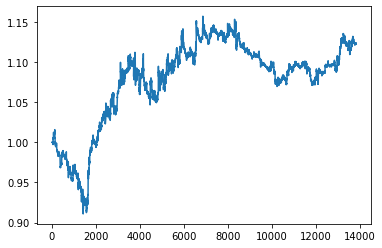

In [45]:
plt.plot((1 + strategy_df['ret']).cumprod())

In [54]:
max_dd(strategy_df)

0.10337439001564794